In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from imageio import imread
import tensorflow as tf

from preprocess import IMAGE_SIZE, MASK_SIZE
from plot_utils import plot_mask, plot_train_process, plot_result

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Define Path

In [2]:
IMAGE_ROOT = './data/images/'
MASK_ROOT = './data/masks/'
image_names = os.listdir(IMAGE_ROOT)
mask_names = os.listdir(MASK_ROOT)
image_paths = [IMAGE_ROOT + name for name in image_names]
mask_paths = [MASK_ROOT + name for name in mask_names]

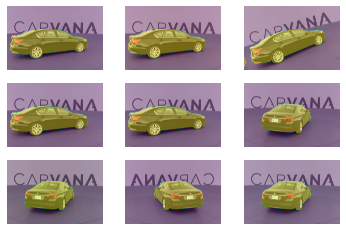

In [3]:
rows = 3
cols = 3
for i in range(rows * cols):
    ax = plt.subplot(rows, cols, i + 1)
    image = imread(image_paths[i])
    mask = imread(mask_paths[i])
    plot_mask(ax, image, mask)

### Load Data

In [4]:
def process_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=3)
    mask = tf.cast(mask, dtype=tf.float32) / 255.
    return image, mask

def preprocess(image, mask):
    image = tf.image.resize(image, IMAGE_SIZE, method='nearest')
    mask = tf.image.resize(mask, IMAGE_SIZE, method='nearest')
    mask = tf.image.central_crop(mask, MASK_SIZE[0] / IMAGE_SIZE[0])
    return image, mask

def load_data():
    path_ds = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = path_ds.map(process_path)
    dataset = dataset.map(preprocess)
    return dataset

dataset = load_data()

In [5]:
for i, j in dataset.take(1):
    print(i.shape, j.shape)

(128, 128, 3) (128, 128, 3)


### Resized And Cropped Image

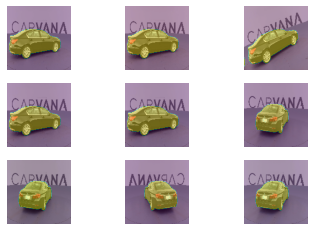

In [6]:
for i, (image, mask) in enumerate(dataset.take(9)):
    ax = plt.subplot(rows, cols, i + 1)
    plot_mask(ax, image, mask)

### Shuffle And Define Batch Size

In [7]:
tf.random.set_seed(0)
batch_size = 4
dataset = dataset.cache().shuffle(len(dataset), reshuffle_each_iteration=False)
test_set = dataset.take(int(len(dataset) * 0.2)).cache().batch(batch_size)
train_set = dataset.skip(int(len(dataset) * 0.2)).cache().batch(batch_size)

### Build Model

In [8]:
def conv_block(X, filters, skips=None, skip_shape=None, pooling=True):
    X = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal')(X)
    X = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, 
    padding='same', activation='relu', kernel_initializer= 'he_normal')(X)

    if skips is not None:
        if skip_shape is None:
            skip_shape = X.shape[1:3]
        skip = tf.keras.layers.CenterCrop(*skip_shape)(X)
        skips.append(skip)
    if pooling:
        X = tf.keras.layers.MaxPool2D(pool_size=2, strides=2)(X)

    return X

def trans_conv_block(X, filters, skip):
    X = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=2, strides=2, padding='valid')(X)
    X =tf.keras.layers.Concatenate(axis=-1)([X, skip])
    X = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal')(X)
    X = tf.keras.layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer= 'he_normal')(X)

    return X

def build_model(input_shape, init_filters=16):
    skips = []
    "-----encode-----"
    X0 = tf.keras.layers.Input(shape=input_shape)

    X = conv_block(X0, init_filters, skips)
    X = conv_block(X, init_filters * 2, skips)
    X = conv_block(X, init_filters * 4, skips)
    X = conv_block(X, init_filters * 8, skips)
    X = conv_block(X, init_filters * 16, pooling=False)

    "-----decode-----"
    X = trans_conv_block(X, init_filters * 8, skips[-1])
    X = trans_conv_block(X, init_filters * 4, skips[-2])
    X = trans_conv_block(X, init_filters * 2, skips[-3])
    X = trans_conv_block(X, init_filters * 1, skips[-4])

    output = tf.keras.layers.Conv2D(filters=1, kernel_size=1, strides=1, padding='same')(X)

    model = tf.keras.Model(inputs=X0, outputs=output, name='UNet')

    return model

In [9]:
channels = 3
model = build_model(IMAGE_SIZE + (channels, ), init_filters=16)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['binary_accuracy'])
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  2320        ['conv2d[0][0]']                 
                                )                                                              

### Train

Epoch 1/30
20/20 [==============================] - 12s 386ms/step - loss: 1.1882 - binary_accuracy: 0.7602 - val_loss: 0.4153 - val_binary_accuracy: 0.8224
Epoch 2/30
20/20 [==============================] - 7s 372ms/step - loss: 0.3510 - binary_accuracy: 0.8671 - val_loss: 0.2317 - val_binary_accuracy: 0.8974
Epoch 3/30
20/20 [==============================] - 7s 352ms/step - loss: 0.2278 - binary_accuracy: 0.9088 - val_loss: 0.1515 - val_binary_accuracy: 0.9487
Epoch 4/30
20/20 [==============================] - 7s 343ms/step - loss: 0.2431 - binary_accuracy: 0.9093 - val_loss: 0.1565 - val_binary_accuracy: 0.9378
Epoch 5/30
20/20 [==============================] - 7s 328ms/step - loss: 0.1874 - binary_accuracy: 0.9196 - val_loss: 0.1727 - val_binary_accuracy: 0.9281
Epoch 6/30
20/20 [==============================] - 7s 351ms/step - loss: 0.2528 - binary_accuracy: 0.9007 - val_loss: 0.2147 - val_binary_accuracy: 0.9373
Epoch 7/30
20/20 [==============================] - 8s 389ms/st

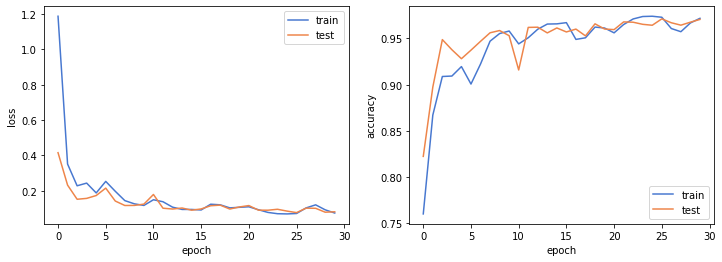

In [10]:
history = model.fit(train_set, validation_data=test_set, epochs=30)
plot_train_process(history)

In [11]:
model.save('./UNet_model.h5', save_format="h5")

### Result

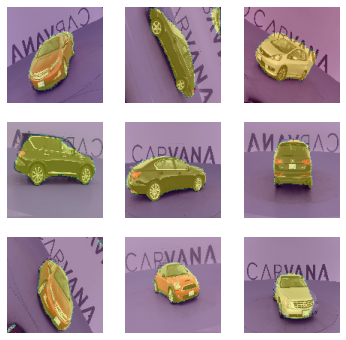

In [12]:
plot_result(test_set, model)